In [1]:
import os
import itertools
import codecs
import re
import datetime
import editdistance
import numpy as np
import pylab
import random
import editdistance
import keras
import pickle
import json
from itertools import cycle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Reshape, Lambda, Flatten
from keras.layers import add, concatenate
from keras.layers import GRU, CuDNNGRU, Conv2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from imageio import imread, imwrite
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import drive

K.set_image_data_format('channels_last')
np.random.seed(0)

Using TensorFlow backend.


In [2]:
drive.mount('/content/gdrive')
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
t_images1 = np.load(folder + "t_images.npy")
t_images2 = np.load(folder + "batchx.npy")
e_labels1 = np.load(folder + "e_labels.npy")
e_labels2 = np.load(folder + "batchye.npy")
label_lens1 = np.load(folder + "label_lens.npy")
label_lens2 = np.load(folder + "batchylen.npy")

In [4]:
len(t_images1), len(t_images2)

(399, 617)

In [0]:
# Download and import model file
!cp '/content/gdrive/My Drive/University/tfg/model/model.py' .
from model import create_model

In [0]:
# Take a test set, only from the turing sequences
turing_lines = len(t_images1)
mask = np.full(turing_lines, False)
mask[:20] = True
np.random.shuffle(mask)
t_images_test = t_images1[mask]
e_labels_test = e_labels1[mask]
label_lens_test = label_lens1[mask]
t_images1 = t_images1[~mask]
e_labels1 = e_labels1[~mask]
label_lens1 = label_lens1[~mask]

In [7]:
len(t_images1), len(t_images_test)

(379, 20)

In [0]:
# Shuffle and train test split
# t_images_train, t_images_test, e_labels_train, e_labels_test, \
#   label_lens_train, label_lens_test =  train_test_split(t_images, \
#   e_labels, label_lens, test_size=10, random_state=99)

In [0]:
t_images = np.concatenate([t_images1, t_images2], axis=0)
e_labels = np.concatenate([e_labels1, e_labels2], axis=0)
label_lens = np.concatenate([label_lens1, label_lens2], axis=0)

In [10]:
t_images.shape, e_labels.shape, label_lens.shape

((996, 170, 30, 1), (996, 19), (996, 1))

In [0]:
# Invert values (black background, white letters)
t_images = 1 - t_images
t_images_test = 1 - t_images_test

In [0]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]
  
t_images_train, e_labels_train, label_lens_train = \
  unison_shuffled_copies(t_images, e_labels, label_lens)

In [0]:
t_images_train, e_labels_train, label_lens_train = \
  shuffle(t_images, e_labels, label_lens, random_state=99)

In [0]:
# Load alphabet
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'
with open(folder + 'alphabet.pickle', 'rb') as handle:
  alphabet = pickle.load(handle)
with open(folder + 'ixchar.pickle', 'rb') as handle:
  ix_to_char = pickle.load(handle)

In [0]:
# Define a parameters dictionary
params = {}

# Data Parameters 
params['img_h'] = t_images.shape[2]
params['img_w'] = t_images.shape[1]
params['input_shape'] = (params['img_w'], params['img_h'], 1)
params['max_string_len'] = int(max([length for length in label_lens]))

# Network parameters
params['conv_filters'] = 32
params['num_convs'] = 2
params['kernel_size'] = (3,3)
params['pool_size'] = 2
params['time_dense_size'] = 64
params['rnn1_size'] = 156
params['rnn2_size'] = 256
params['ctc_cut'] = 2
params['output_size'] = len(alphabet) + 1
params['act'] = 'relu'

batch_size = 64

In [0]:
# Save parameters for use in production
with open('/content/gdrive/My Drive/University/tfg/model/params.json', 'w') as file:
  file.write(json.dumps(params, indent=2))

In [17]:
# A tensor where all values are the same, is required by ctc loss
ctc_input_length = (params['img_w'] // (params['pool_size'] ** params['num_convs'])) - params['ctc_cut']
ctc_input_length = np.expand_dims(np.array([ctc_input_length] * len(t_images)), 1)
ctc_input_length.shape

(996, 1)

In [0]:
def label_to_text(ixes):
  ret = []
  for c in ixes:
    if c == len(alphabet) or c == -1:  # CTC Blank
      ret.append("")
    else:
      ret.append(ix_to_char[c])
  return "".join(ret)

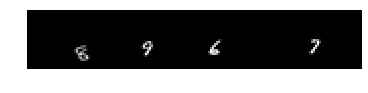

The label is:  8967
Should match:  [4.] 4


In [19]:
# Explore the data, check that everything is correct
i = random.randint(0, len(t_images_train)-1)
plt.imshow(np.squeeze(t_images_train[i].T), cmap='gray')
plt.axis('off')
plt.show()
print("The label is: ", label_to_text(e_labels_train[i]))
print("Should match: ", label_lens_train[i], len(label_to_text(e_labels_train[i])))

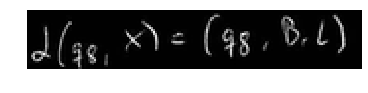

The label is:  d(q8,X)=(q8,B,L)


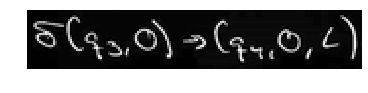

The label is:  d(q3,0)=(q4,0,L)


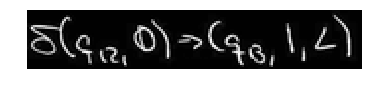

The label is:  d(q12,0)=(q13,1,L)


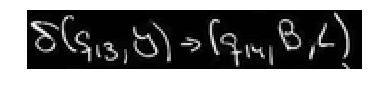

The label is:  d(q13,Y)=(q14,B,L)


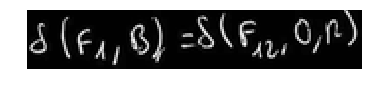

The label is:  d(F1,B)=d(F12,0,R)


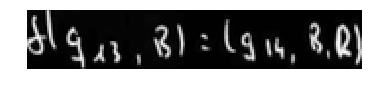

The label is:  d(q13,B)=(q14,B,R)


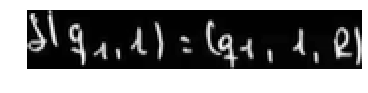

The label is:  d(q1,1)=(q1,1,R)


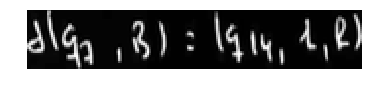

The label is:  d(q7,B)=(q14,1,R)


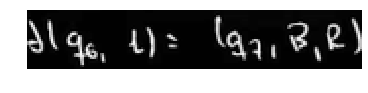

The label is:  d(q6,1)=(q7,B,R)


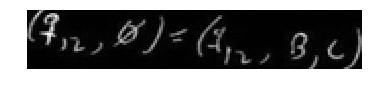

The label is:  (q12,0)=(q12,B,L)


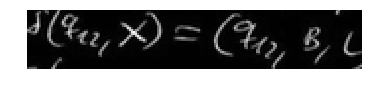

The label is:  d(q12,X)=(q12,B,L)


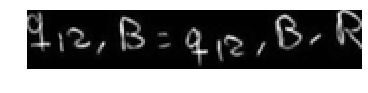

The label is:  q12,B=q12,B,R


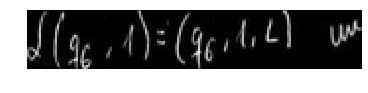

The label is:  d(q6,1)=(q6,1,L)


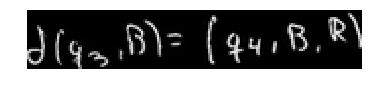

The label is:  d(q3,B)=(q4,B,R)


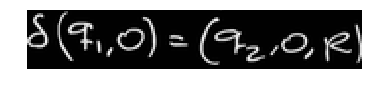

The label is:  d(q1,0)=(q2,0,R)


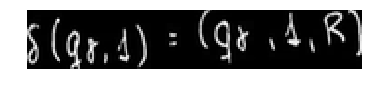

The label is:  d(q8,1)=(q8,1,R)


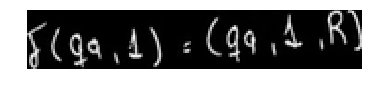

The label is:  d(q9,1)=(q9,1,R)


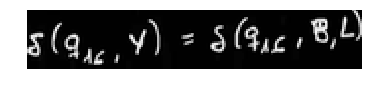

The label is:  d(q16,Y)=d(q16,B,L)


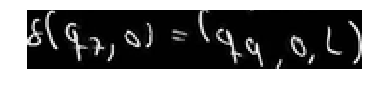

The label is:  d(q7,0)=(q9,0,L)


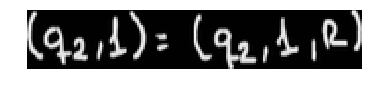

The label is:  (q2,1)=(q2,1,R)


In [20]:
# Show all test images
for i in range(len(t_images_test)):
  plt.imshow(np.squeeze(t_images_test[i].T), cmap='gray')
  plt.axis('off')
  plt.show()
  print("The label is: ", label_to_text(e_labels_test[i]))

In [0]:
# Check shapes
t_images.shape, e_labels.shape, ctc_input_length.shape, label_lens.shape

In [0]:
model, decoder_models = create_model(params, gpu=False)

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
#model.summary()

In [0]:
# Data Augmentation
data_gen_args = dict(
    rotation_range = 2,
    zoom_range = (1,1.1),
    shear_range = 8,
    fill_mode = "constant",
    cval = 0.0,
    data_format = 'channels_last',
)
image_datagen = ImageDataGenerator(**data_gen_args)
image_flow = image_datagen.flow(t_images_train, batch_size=1, shuffle=False)

In [0]:
def get_data_round():
  image_round = []
  for _ in range(len(t_images_train)):
    image_round.append(np.squeeze(next(image_flow),axis=0))
  return [image_round, e_labels_train, ctc_input_length[:len(t_images_train)], 
          label_lens_train]

In [0]:
# Testing the data comming from the generator
testing_imgs, testing_lbs, _, _ = get_data_round()
r = random.randint(0, len(t_images) - 6)
for i in range(r, r+5):
  img = testing_imgs[i]
  plt.imshow(np.squeeze(img.T), cmap='gray')
  plt.axis('off')
  plt.show()
  print(label_to_text(testing_lbs[i]))

In [0]:
# Edit distance metric ...
def edit_distance(y_true, y_pred):
  total = 0
  for true, pred in zip(y_true, y_pred):
    true = label_to_text(list(np.squeeze(true)))
    pred = label_to_text(list(np.squeeze(pred)))
    total += editdistance.eval(true, pred)
  return total / len(y_true)

In [0]:
number = 16
# model.load_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/model_{number}.h5')

In [0]:
# To name weight files
i = 0

In [0]:
# For plotting
losses = []
edit_values = []

In [0]:
def print_test_results(show=False):
  decoder0, decoder1, decoder2 = decoder_models
  # Look at the test results
  total_edit_distance = 0
  for j in range(len(t_images_test)):
    decoded0 = decoder0([t_images_test[j:j+1], ctc_input_length[j:j+1]])
    decoded1 = decoder1([t_images_test[j:j+1], ctc_input_length[j:j+1]])
    decoded2 = decoder2([t_images_test[j:j+1], ctc_input_length[j:j+1]])
    if show:
      plt.imshow(np.squeeze(t_images_test[j].T), cmap='gray')
      plt.axis('off')
      plt.show()
      print("True label:   ", label_to_text(list(np.squeeze(e_labels_test[j]))))
      print("Prediction 1: ", label_to_text(list(np.squeeze(decoded0))))
      print("Prediction 2: ", label_to_text(list(np.squeeze(decoded1))))
      print("Prediction 3: ", label_to_text(list(np.squeeze(decoded2))))
    distance = editdistance.eval(label_to_text(e_labels_test[j]),
                        label_to_text(list(np.squeeze(decoded0))))
    total_edit_distance += distance
    if show: print(f"Edit distance: {distance}")
    
  average_distance = total_edit_distance / len(t_images_test)
  print(f"Average test edit distance: {average_distance}")
  edit_values.append(average_distance)

In [0]:
# Initial fast approximation
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.001))
history = model.fit(
        x = get_data_round(),
        y = np.zeros(len(t_images_train)),
        batch_size=128,
        epochs=20,
        verbose=0,
        #validation_split=0.15,
)

In [0]:
# # Long training
# model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.001))
# for j in range(50):
#   data_round = get_data_round()
#   history = model.fit(
#           x = data_round,
#           y = np.zeros(len(t_images_train)),
#           batch_size=64,
#           epochs=5,
#           verbose=0,
#           validation_split=0.2,
#           shuffle=False,
#          )
#   print(f"Iteration {j:0>2}: loss: {np.min(history.history['loss']):5.2f}, validation loss: {np.min(history.history['val_loss']):5.2f}")
#   if (j+1) % 10 == 0:
#     i += 1
#     print(f"Saving weights, model: {i}!")
#     model.save_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/modelnew_{i}.h5')

In [0]:
# Long training with test set checking
for _ in range(15):
  model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0005))
  for j in range(3):
    data_round = get_data_round()
    history = model.fit(
            x = data_round,
            y = np.zeros(len(t_images_train)),
            batch_size=64,
            epochs=5,
            verbose=0,
           )
    losses.extend(history.history['loss'])
    print(f"Iteration {j:0>2}: loss: {np.min(history.history['loss']):5.2f}")
  print_test_results()
#   if (j+1) % 10 == 0:
#     i += 1
#     print(f"Saving weights, model: {i}!")
#     model.save_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/modelnew_{i}.h5')

In [0]:
print_test_results()

In [0]:
edit_values

In [0]:
# Plot graphcs
plt.plot(losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(edit_values)
plt.title('edit distance')
plt.ylabel('edit distance')
plt.xlabel('epoch / 15')
plt.show()

In [0]:
# i += 1
# print(f"Saving weights, model: {i}!")
# model.save_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/model_{i}.h5')

In [0]:
# Save final model for production
# model.save_weights('/content/gdrive/My Drive/University/tfg/model/weights.h5')

In [0]:
# Load production weights
# model.load_weights('/content/gdrive/My Drive/University/tfg/backend/weights.h5')

In [0]:
# Compute training dataset edit distance
decoder0, decoder1, decoder2 = decoder_models
total_edit_distance = 0
for j in range(len(t_images_train)):
  decoded0 = decoder0([t_images_train[j:j+1], ctc_input_length[j:j+1]])[0]
  true = label_to_text(list(np.squeeze(e_labels_train[j])))
  if decoded0.size:
    predicted = label_to_text(list(np.squeeze(decoded0, axis=0)))
  else:
    predicted = ""
  distance = editdistance.eval(true, predicted)
  total_edit_distance += distance
  
print(f"Average training edit distance: {total_edit_distance / len(t_images_train)}")

In [0]:
# # Compute training dataset edit distance (in batch, WIP)
# total_edit_distance = 0
# decoded0 = decoder0([t_images_train, ctc_input_length[:len(t_images_train)]])[0]
# trues = []
# preds = []
# for label in list(np.squeeze(e_labels_train[j])):
#   trues.append(label_to_text(label))
# for dec in decoded0:
#   preds.append(label_to_text(list(dec)))

# for true, pred in trues, preds:
#   distance = editdistance.eval(true, pred)
#   total_edit_distance += distance
  
# print(f"Average edit distance: {total_edit_distance / len(t_images_train)}")